In [1]:
import sys
sys.path.append('..')

from scripts.GenrationGI0 import partitioned_gi0_image
from scripts.autoencoders import InMemoryImageDataset, generate_multiple_images, ConfigurableAutoencoder

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2
from omegaconf import OmegaConf
OmegaConf.register_new_resolver("eval", eval)

Elegir el archivo de configuración correspondiente:

In [2]:
config_path = 'configs/config_base.yaml'

config = OmegaConf.load(config_path)
config

{'training': {'n': 50000, 'n_cuad_lado': 2, 'pixeles_cuad': 25, 'num_epochs': 20, 'batch_size': 64, 'learning_rate': 0.001}, 'model': {'encoding_dim': 32, 'loss_function': 'mse', 'optimizer': 'adam'}, 'encoder': {'layers': [{'type': 'conv2d_transpose', 'filters': 1, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'sigmoid'}, {'type': 'flatten'}, {'type': 'dense', 'dim': 128, 'activation': 'relu'}, {'type': 'dense', 'dim': '${model.encoding_dim}'}]}, 'decoder': {'layers': [{'type': 'dense', 'dim': 128, 'activation': 'relu'}, {'type': 'dense', 'dim': "${eval:'(${training.n_cuad_lado} * ${training.pixeles_cuad})**2'}", 'activation': 'sigmoid'}, {'type': 'unflatten', 'dim1': "${eval:'${training.n_cuad_lado} * ${training.pixeles_cuad}'}", 'dim2': "${eval:'${training.n_cuad_lado} * ${training.pixeles_cuad}'}"}]}, 'testing': {'n': 1000, 'batch_size': 32}}

---
# Creación del dataset para entrenar

In [3]:
n = config['training']['n']
n_cuad_lado = config['training']['n_cuad_lado']
pixeles_cuad = config['training']['pixeles_cuad']
batch_size = config['training']['batch_size']

In [4]:
train_g, train_gi, train_gI0 = generate_multiple_images(n, partitioned_gi0_image, n_cuad_lado, pixeles_cuad)

In [5]:
normalize_to_01 = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_to_01
])

dataset_train = InMemoryImageDataset(train_gI0, train_gi, transform=transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

---
# Entrenamiento

In [6]:
learning_rate = config['training']['learning_rate']
num_epochs = config['training']['num_epochs']

In [7]:
autoencoder = ConfigurableAutoencoder(config=config)
autoencoder

ConfigurableAutoencoder(
  (encoder): Sequential(
    (0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=2500, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2500, bias=True)
    (3): Sigmoid()
    (4): Unflatten(dim=1, unflattened_size=(1, 50, 50))
  )
)

In [8]:
loss = config['model']['loss_function'].lower()
opt = config['model']['optimizer'].lower()

if loss == 'mse':
    criterion = nn.MSELoss()
elif loss == 'bce':
    criterion = nn.BCELoss()

if opt == 'adam':
    optimizer = optim.Adam(
        autoencoder.parameters(), 
        lr=learning_rate
    )
elif optim == 'sgd':
    optimizer = optim.SGD(
        autoencoder.parameters(), 
        lr=learning_rate
    )

In [9]:
training_losses = []

for epoch in range(num_epochs):
    epoch_losses = []
    
    for data in train_loader:
        entrada, salida = data
        entrada = entrada.float()
        salida = salida.float()

        # Forward pass
        outputs = autoencoder(entrada) # Se pasa a las imágenes por el autoencoder, en una pasada forward.
        loss = criterion(outputs, salida) # Se calcula la diferencia entre el output y las imágenes sin ruido, según la función de pérdida definida.

        # Backward pass y optimización
        optimizer.zero_grad() # Se restablecen los gradientes acumulados en todos los parámetros del modelo.
                              # Esto es necesario antes de realizar el backward pass, ya que PyTorch acumula los gradientes en cada llamada a loss.backward().
        loss.backward() # Se realiza el backward pass para calcular los gradientes de los parámetros del autoencoder utilizando la función de pérdida.
        optimizer.step() # Finalmente se realiza la optimización de los parámetros del modelo mediante la llamada a optimizer.step(), que actualiza los parámetros en función de los gradientes calculados.

        epoch_losses.append(loss.item())
        
    avg_loss = np.mean(epoch_losses)
    training_losses.append(avg_loss)
    
    # Imprimir la pérdida del autoencoder en cada época
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 0.0074
Epoch [2/20], Loss: 0.0036
Epoch [3/20], Loss: 0.0029
Epoch [4/20], Loss: 0.0027
Epoch [5/20], Loss: 0.0027
Epoch [6/20], Loss: 0.0026
Epoch [7/20], Loss: 0.0026
Epoch [8/20], Loss: 0.0026
Epoch [9/20], Loss: 0.0026
Epoch [10/20], Loss: 0.0026
Epoch [11/20], Loss: 0.0026
Epoch [12/20], Loss: 0.0026
Epoch [13/20], Loss: 0.0026
Epoch [14/20], Loss: 0.0026
Epoch [15/20], Loss: 0.0026
Epoch [16/20], Loss: 0.0026
Epoch [17/20], Loss: 0.0026
Epoch [18/20], Loss: 0.0025
Epoch [19/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025


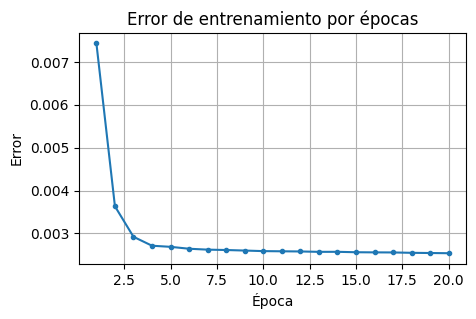

In [10]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs + 1), training_losses, '.-')
plt.title('Error de entrenamiento por épocas')
plt.xlabel('Época')
plt.ylabel('Error')
plt.grid()

---
# Evaluación

In [11]:
n = config['testing']['n']
batch_size = config['testing']['batch_size']

In [12]:
test_g, test_gi, test_gI0 = generate_multiple_images(n, partitioned_gi0_image, n_cuad_lado, pixeles_cuad)

In [13]:
dataset_test = InMemoryImageDataset(test_gI0, test_gi, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [14]:
total_loss = 0
with torch.no_grad(): # Esto es para asegurarse de que no se realicen cálculos de gradientes durante la evaluación del autoencoder.
                      # Al entrar en este bloque, se desactiva el cálculo y almacenamiento automático de gradientes para reducir el uso de memoria y acelerar la evaluación.
    for data in test_loader:
        entrada, salida = data
        entrada = entrada.float()
        salida = salida.float()

        # Forward pass
        outputs = autoencoder(entrada) # Se realiza el forward pass del autoencoder con las imágenes de prueba.
                                       # El autoencoder genera las imágenes reconstruidas utilizando el método forward() que definimos previamente en la clase Autoencoder.
        loss = criterion(outputs, salida) # Se calcula la pérdida entre las imágenes reconstruidas y las imágenes originales utilizando la función de pérdida (criterion).
                                          # Esto proporciona una medida de cuánto difieren las imágenes reconstruidas de las originales.
        total_loss += loss.item() # La pérdida obtenida en cada iteración se suma a la variable total_loss utilizando loss.item(), que devuelve el valor escalar de la pérdida.
                                  # Al final de la iteración, total_loss contendrá la suma acumulada de las pérdidas de todas las muestras del conjunto de datos de prueba.

average_loss = total_loss / len(test_loader) # Se calcula la pérdida promedio dividiendo la suma acumulada de las pérdidas (total_loss) entre el número de lotes en el conjunto de datos de prueba (len(test_loader)).
                                             # Esto proporciona una medida promedio de la discrepancia entre las imágenes originales y las imágenes reconstruidas por el autoencoder en el conjunto de datos de prueba.
print(f"Average Test Loss: {average_loss:.4f}")

Average Test Loss: 0.0026


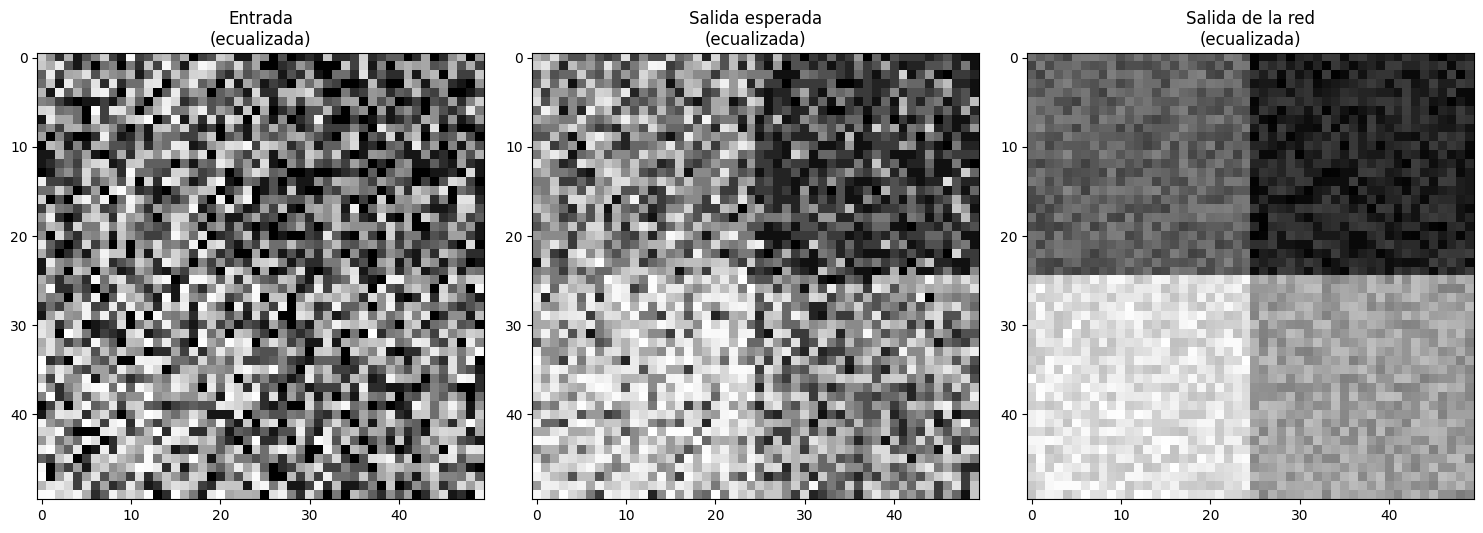

In [15]:
# Aplico el autoencoder a un ejemplo particular del dataset de testeo y veo cómo queda la
# imagen de salida.

ecualizar_hist = True  # Si se quiere o no ecualizar el histograma de la imagen

###

index = int(n*np.random.random()) # Índice del ejemplo puntual que se desea seleccionar
entrada_red, salida_red = dataset_test[index]

example = entrada_red.float()

reconstructed = autoencoder(example) # Aplica el autoencoder al ejemplo

tamanio = n_cuad_lado*pixeles_cuad

entrada = entrada_red.view(tamanio, tamanio)
salida_esperada = salida_red.view(tamanio, tamanio)
reconstructed = reconstructed.view(tamanio, tamanio)

imagenes = [entrada, salida_esperada, reconstructed.detach()]
titulos = ['Entrada', 'Salida esperada', 'Salida de la red']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, imagen, titulo in zip(axes, imagenes, titulos):
    if ecualizar_hist:
        im = imagen.cpu().numpy()
        im = ((im - im.min()) * 255) / (im.max() - im.min())
        imagen = cv2.equalizeHist(im.astype(np.uint8))
        titulo += '\n(ecualizada)'
    
    ax.imshow(imagen, cmap='gray')
    ax.set_title(titulo)

plt.tight_layout()